In [290]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA  # For Fancy PCA (data augmentation)
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

import plotly.express as px
import lasio as ls
import missingno as mno

In [291]:
import warnings

# Suppress specific deprecation warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.metrics")

In [292]:
import os

np.random.seed(42)
tf.random.set_seed(42)
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Data Preparation

In [293]:
combined_df = pd.read_csv('data/combined_df_VMM.csv')

<Axes: >

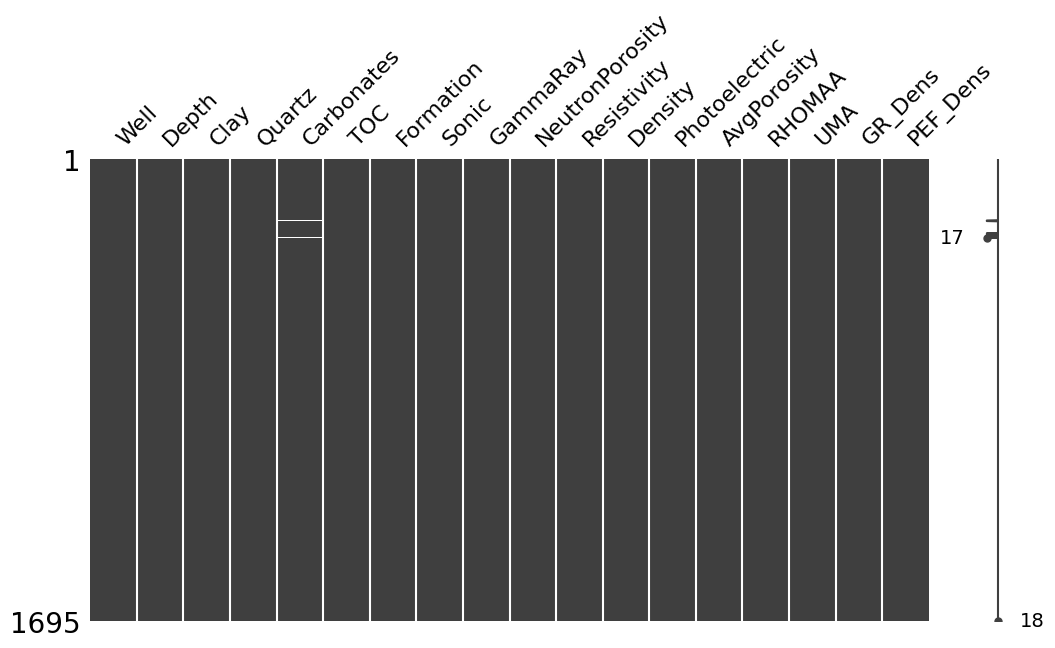

In [294]:
# check nans of combined_df with msno
mno.matrix(combined_df, figsize=(12, 6))    

In [295]:
# fill nans with interpolation
combined_df = combined_df.interpolate(method='linear', limit_direction='both')

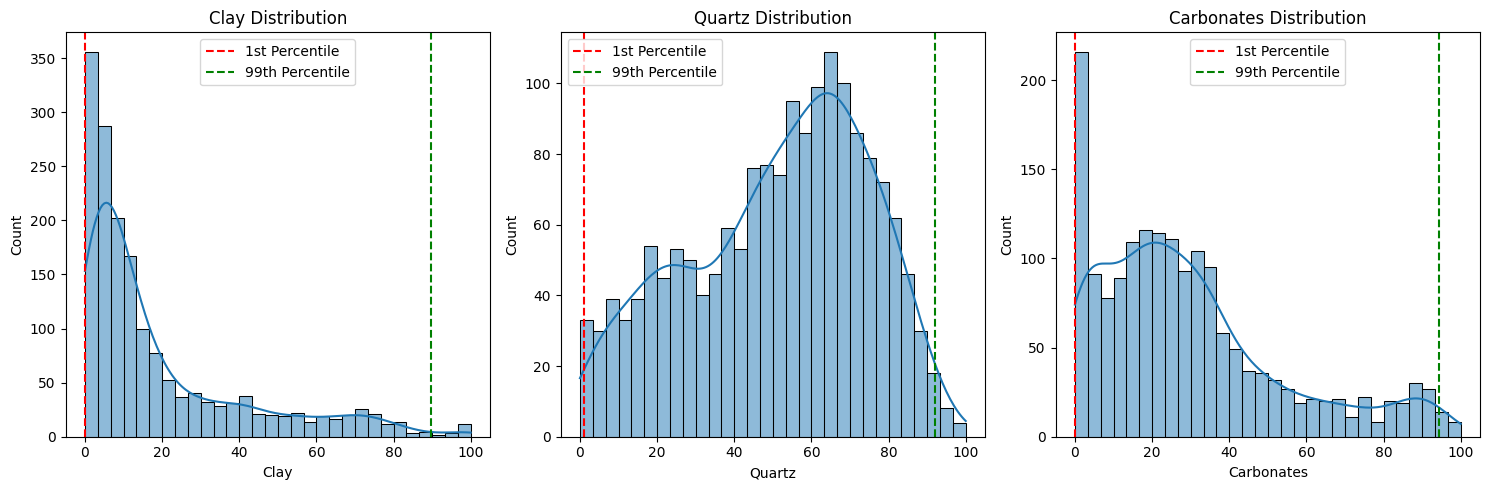

In [296]:
# show percentiles 1 and 99 for each clay, quartz, and carbonate in an histogram

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, feature in enumerate(['Clay', 'Quartz', 'Carbonates']):
    sns.histplot(combined_df[feature], bins=30, kde=True, ax=ax[i])
    ax[i].set_title(f"{feature} Distribution")
    ax[i].axvline(combined_df[feature].quantile(0.01), color='red', linestyle='--', label='1st Percentile')
    ax[i].axvline(combined_df[feature].quantile(0.99), color='green', linestyle='--', label='99th Percentile')
    ax[i].legend()

plt.tight_layout()
plt.show()

In [297]:
combined_df.columns

Index(['Well', 'Depth', 'Clay', 'Quartz', 'Carbonates', 'TOC', 'Formation',
       'Sonic', 'GammaRay', 'NeutronPorosity', 'Resistivity', 'Density',
       'Photoelectric', 'AvgPorosity', 'RHOMAA', 'UMA', 'GR_Dens', 'PEF_Dens'],
      dtype='object')

In [298]:
for col in ['Clay', 'Quartz', 'Carbonates']:
    p1 = combined_df[col].quantile(0.01)
    p99 = combined_df[col].quantile(0.99)
    combined_df = combined_df[(combined_df[col] >= p1) & (combined_df[col] <= p99)]

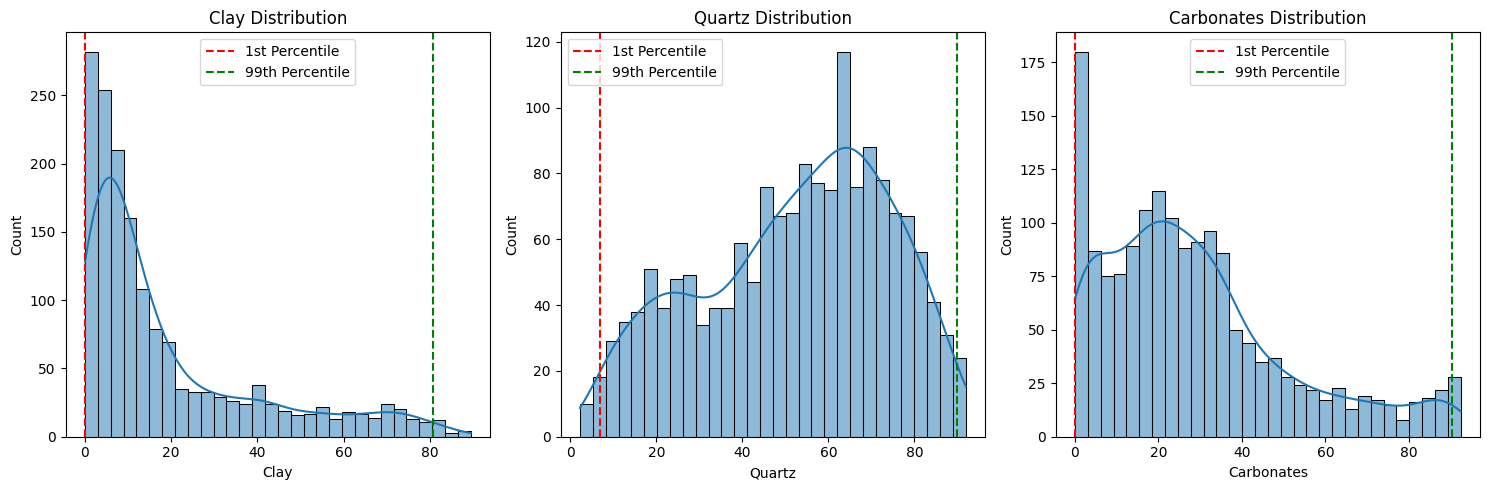

In [299]:
# show percentiles 1 and 99 for each clay, quartz, and carbonate in an histogram

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, feature in enumerate(['Clay', 'Quartz', 'Carbonates']):
    sns.histplot(combined_df[feature], bins=30, kde=True, ax=ax[i])
    ax[i].set_title(f"{feature} Distribution")
    ax[i].axvline(combined_df[feature].quantile(0.01), color='red', linestyle='--', label='1st Percentile')
    ax[i].axvline(combined_df[feature].quantile(0.99), color='green', linestyle='--', label='99th Percentile')
    ax[i].legend()

plt.tight_layout()
plt.show()

In [300]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import pandas as pd

# Define features (well logs) and target variables (minerals)
features = ['GammaRay', 'Sonic', 'Density', 'Resistivity', 'NeutronPorosity', 'Photoelectric']
target = ['Carbonates', 'Clay', 'Quartz']

X = combined_df[features]
y = combined_df[target]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data if needed
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [301]:
# Convert the target columns to numeric
y_train['Carbonates'] = pd.to_numeric(y_train['Carbonates'], errors='coerce')
y_train['Clay'] = pd.to_numeric(y_train['Clay'], errors='coerce')
y_train['Quartz'] = pd.to_numeric(y_train['Quartz'], errors='coerce')

# Check if the conversion worked
print(y_train.dtypes)

Carbonates    float64
Clay          float64
Quartz        float64
dtype: object


<Axes: >

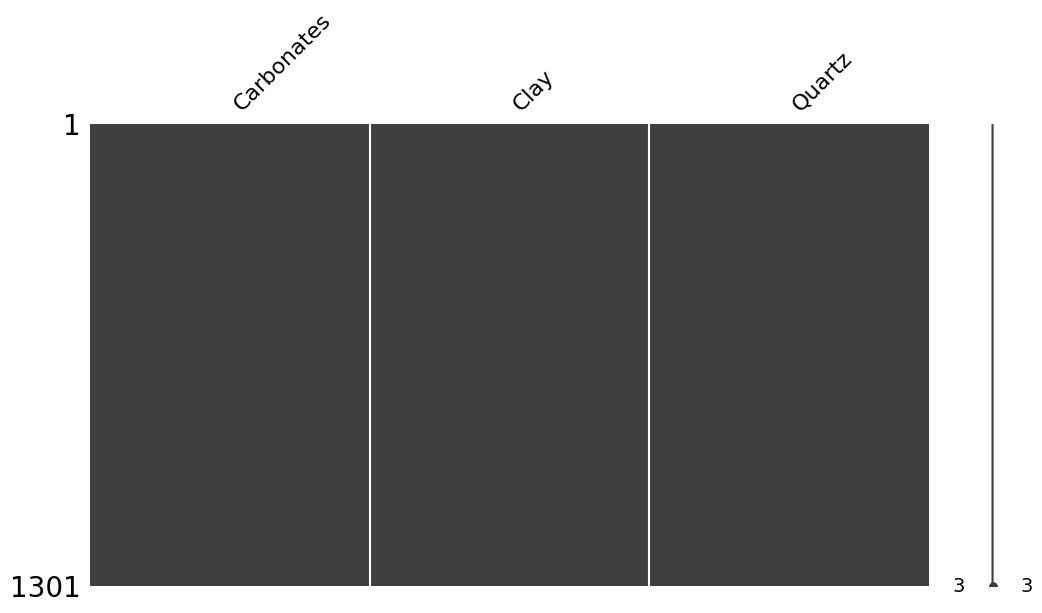

In [302]:
import missingno as mno

# Visualize missing values in the training set
mno.matrix(y_train, figsize=(12, 6))

## Build and train the model with weights

In [303]:
import numpy as np
import pandas as pd

# Calculate weights based on 15-bin histogram for each target
def calculate_weights(y, bins=15):
    # Calculate the bin frequencies for each target variable
    weights = np.zeros(y.shape)
    for i, col in enumerate(y.columns):
        hist, bin_edges = np.histogram(y[col], bins=bins)
        max_freq = np.max(hist)
        bin_weights = np.zeros(len(y[col]))

        # Assign weights based on the inverse of the bin frequency
        for j in range(bins):
            bin_mask = (y[col] >= bin_edges[j]) & (y[col] < bin_edges[j+1])
            freq = hist[j]
            if freq > 0:
                bin_weights[bin_mask] = max_freq / freq

        # If the value equals the last bin edge (e.g., max value), set the weight
        bin_weights[y[col] == bin_edges[-1]] = max_freq / hist[-1]
        weights[:, i] = bin_weights

    return weights

# Calculate weights for the training set
sample_weights = calculate_weights(y_train)

# Check the shape of the weights array
print(f"Shape of sample weights: {sample_weights.shape}")

Shape of sample weights: (1301, 3)


In [305]:
from keras import models, layers, regularizers

# Define the updated model architecture
def create_updated_model():
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(X_train_scaled.shape[1],)))
    model.add(layers.Dense(256, kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(128, kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dense(3, activation='linear'))  # Predicting Calcite, Clay, and Quartz
    model.compile(optimizer='adam', loss='mse')
    return model

# Initialize and train the model with sample weights
updated_model = create_updated_model()

# For each target variable, assign the corresponding column of weights
history = updated_model.fit(X_train_scaled, y_train, 
                            sample_weight=sample_weights.mean(axis=1),  # Average weights for multi-output
                            validation_data=(X_test_scaled, y_test), 
                            epochs=50, batch_size=32, verbose=1)

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 5333.6987 - val_loss: 1723.9653
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4897.0088 - val_loss: 1689.0775
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4557.6250 - val_loss: 1663.8431
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4230.5234 - val_loss: 1612.2195
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3905.0723 - val_loss: 1515.7484
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3583.6619 - val_loss: 1383.7917
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3246.3008 - val_loss: 1199.0868
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2919.3782 - val_loss: 1047.4025
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2600.5342 - val_loss: 930.9568
Epoch 10/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2321.8198 - val_loss: 837.3193
Epoch 11/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2067.7458 - val_loss: 754.6108
Epoch 12/50

In [306]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predict on the test set
y_pred = updated_model.predict(X_test_scaled)

# Define function to calculate normalized RMSE and nMAE
def calculate_normalized_error(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    nrmse = rmse / (y_true.max() - y_true.min())
    nmae = mae / (y_true.max() - y_true.min())
    r2 = r2_score(y_true, y_pred)
    return nrmse, nmae, r2

# Calculate metrics for Calcite
nrmse_calcite, nmae_calcite, r2_calcite = calculate_normalized_error(y_test['Carbonates'], y_pred[:, 0])

# Calculate metrics for Clay
nrmse_clay, nmae_clay, r2_clay = calculate_normalized_error(y_test['Clay'], y_pred[:, 1])

# Calculate metrics for Quartz
nrmse_quartz, nmae_quartz, r2_quartz = calculate_normalized_error(y_test['Quartz'], y_pred[:, 2])

# Print final metrics
print(f"nRMSE for Calcite: {nrmse_calcite:.2f}, nMAE: {nmae_calcite:.2f}, R²: {r2_calcite:.2f}")
print(f"nRMSE for Clay: {nrmse_clay:.2f}, nMAE: {nmae_clay:.2f}, R²: {r2_clay:.2f}")
print(f"nRMSE for Quartz: {nrmse_quartz:.2f}, nMAE: {nmae_quartz:.2f}, R²: {r2_quartz:.2f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
nRMSE for Calcite: 0.22, nMAE: 0.16, R²: 0.13
nRMSE for Clay: 0.24, nMAE: 0.17, R²: 0.03
nRMSE for Quartz: 0.20, nMAE: 0.16, R²: 0.33


In [307]:
# Verify the shape of y_test and y_pred
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred.shape}")

# Print a few sample predictions vs actual values
print("Sample Predictions vs Actuals:")
print(f"Predicted Calcite: {y_pred[:5, 0]}")
print(f"Actual Calcite: {y_test['Carbonates'].values[:5]}")

Shape of y_test: (326, 3)
Shape of y_pred: (326, 3)
Sample Predictions vs Actuals:
Predicted Calcite: [27.4597    11.346632  49.48944   15.657863   2.9149618]
Actual Calcite: [25.02935212 18.79731776 43.21467098 30.80942851  1.90313269]


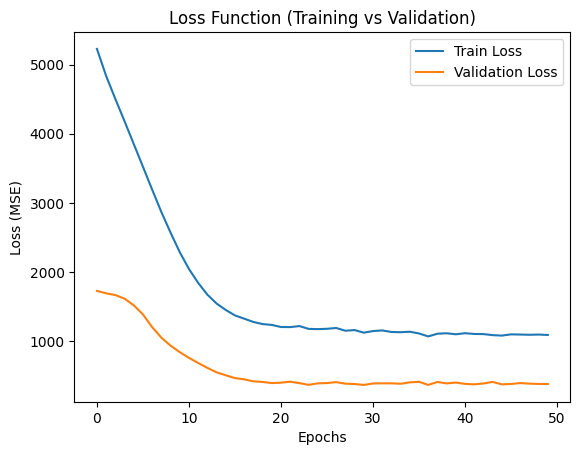

In [308]:
# Plot loss function
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Function (Training vs Validation)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

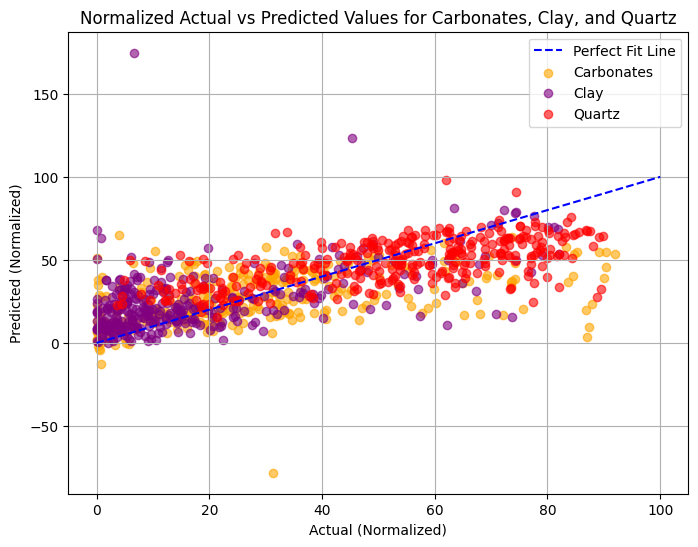

In [309]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
# Create the plot
plt.figure(figsize=(8, 6))


# Plot the perfect fit line (0-1 diagonal)
plt.plot([0, 100], [0, 100], 'b--', label='Perfect Fit Line')

# Plot for Calcite
plt.scatter(y_test['Carbonates'], y_pred[:, 0], label='Carbonates', color='orange', alpha=0.6)

# Plot for Clay
plt.scatter(y_test['Clay'], y_pred[:, 1], label='Clay', color='purple', alpha=0.6)

# Plot for Quartz
plt.scatter(y_test['Quartz'], y_pred[:, 2], label='Quartz', color='red', alpha=0.6)

# Add labels and title
plt.xlabel('Actual (Normalized)')
plt.ylabel('Predicted (Normalized)')
plt.title('Normalized Actual vs Predicted Values for Carbonates, Clay, and Quartz')

# Add legend and show the plot
plt.legend()
plt.grid(True)
plt.show()

### PCA analysis and augmentation

In [320]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Set random seed for NumPy
np.random.seed(42)

# Define the number of synthetic samples per original sample
num_samples = 5  # Adjust as needed

# Separate features and labels
features = ['GammaRay', 'Sonic', 'Density', 'Resistivity', 'NeutronPorosity', 'Photoelectric']
labels = ['Carbonates', 'Clay', 'Quartz']

X = combined_df[features]
y = combined_df[labels]

# Normalize the features separately
feature_scaler = MinMaxScaler()
X_scaled = feature_scaler.fit_transform(X)

# Normalize the labels separately
label_scaler = MinMaxScaler()
y_scaled = label_scaler.fit_transform(y)

# Split the dataset into training and testing sets with a fixed random state
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.3, random_state=42
)

# Combine scaled features and labels for PCA
combined_train = np.hstack((X_train, y_train))

# Check the shape of the combined dataset
print(f"Shape of combined_train: {combined_train.shape}")

# Apply PCA to the combined training dataset
n_components = min(combined_train.shape[0], combined_train.shape[1])  # Minimum of samples or features
pca = PCA(n_components=n_components, random_state=42)
combined_train_pca = pca.fit_transform(combined_train)

# Function for augmenting data using Fancy PCA
def fancy_pca_augment(combined_data, num_samples, pca, noise_scale=0.1, seed=42):
    augmented_data = []
    rng = np.random.default_rng(seed)  # Use NumPy's Generator for random number generation
    for i in range(num_samples):
        # Add noise to the principal components
        noise = rng.normal(scale=noise_scale, size=combined_data.shape)
        augmented_pca = combined_data + noise
        # Transform back to the original space
        augmented_data.append(pca.inverse_transform(augmented_pca))
    return np.vstack(augmented_data)

# Augment the combined training data
augmented_combined_train = fancy_pca_augment(
    combined_train_pca, num_samples, pca, noise_scale=0.01, seed=42
)

# Split the augmented data back into features and labels
X_train_aug = augmented_combined_train[:, :X_train.shape[1]]
y_train_aug = augmented_combined_train[:, X_train.shape[1]:]

# Combine original and augmented datasets
X_train_combined = np.vstack((X_train, X_train_aug))
y_train_combined = np.vstack((y_train, y_train_aug))

# Ensure data shapes match
print(f"Shape of X_train_combined: {X_train_combined.shape}")
print(f"Shape of y_train_combined: {y_train_combined.shape}")

# Apply PCA to the combined training dataset for further usage
pca_combined = PCA(
    n_components=min(X_train_combined.shape[0], X_train_combined.shape[1]),
    random_state=42
)
X_train_combined_pca = pca_combined.fit_transform(X_train_combined)

# Apply PCA to the test set (note: PCA is fitted on the training set only)
X_test_pca = pca_combined.transform(X_test)

# Print the size of the original and augmented training set
print(f"Original training set size: {X_train.shape[0]}")
print(f"Augmented training set size: {X_train_combined.shape[0]} (including augmented samples)")

# Optionally, print the number of augmented samples generated
augmented_samples = X_train_combined.shape[0] - X_train.shape[0]
print(f"Number of augmented samples: {augmented_samples}")

Shape of combined_train: (1138, 9)
Shape of X_train_combined: (6828, 6)
Shape of y_train_combined: (6828, 3)
Original training set size: 1138
Augmented training set size: 6828 (including augmented samples)
Number of augmented samples: 5690


In [321]:
# Verify the number of components
print(f"Number of PCA components: {pca_combined.n_components_}")

Number of PCA components: 6


Length of pca_contributions: 9
Length of features: 6
Length of components: 9


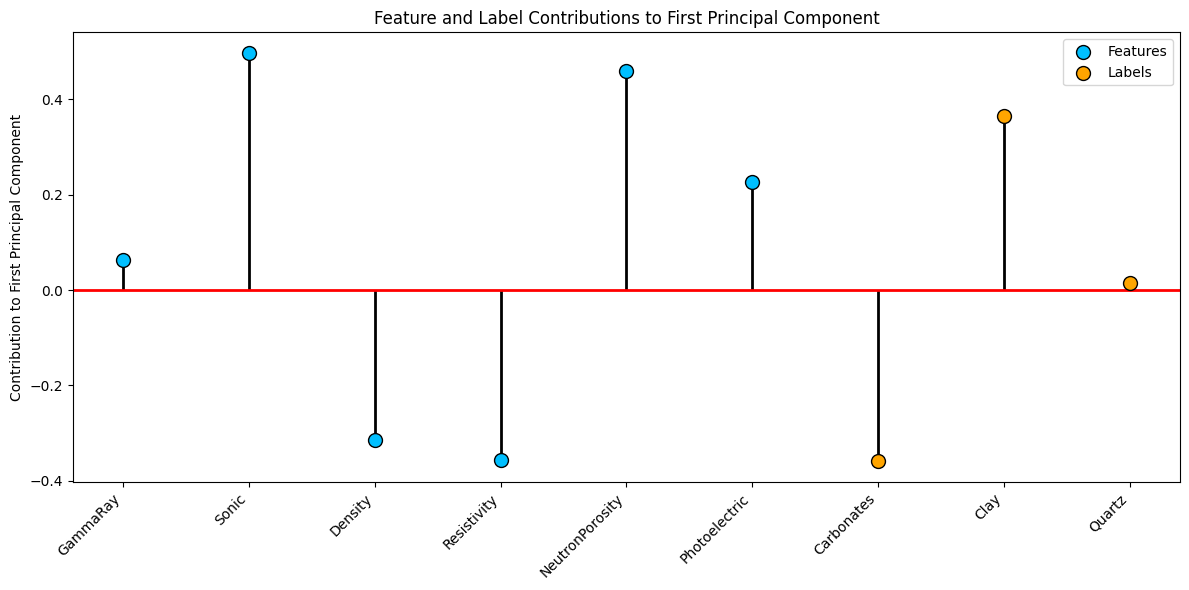

In [322]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Define the feature and label names
features = features
labels = ['Carbonates', 'Clay', 'Quartz']  # Adjust according to your target variables

# Combine features and labels for display purposes
components = features + labels

# Ensure data scaling for features and labels separately
scaler_features = StandardScaler()
scaler_labels = StandardScaler()

# Fit and transform features and labels
X_train_scaled = scaler_features.fit_transform(X_train)
y_train_scaled = scaler_labels.fit_transform(y_train)

# Combine scaled features and labels for PCA
combined_train_scaled = np.hstack((X_train_scaled, y_train_scaled))

# Apply PCA to the combined training dataset
pca_combined = PCA()
combined_train_pca = pca_combined.fit_transform(combined_train_scaled)

# Get the first principal component contributions
pca_contributions = pca_combined.components_[0]

# Check the number of PCA components and ensure it matches the length of combined features and labels
if len(pca_contributions) != len(components):
    print(f"Warning: PCA components ({len(pca_contributions)}) do not match the number of features + labels ({len(components)}).")
    # Set the number of components to the minimum of PCA components and combined features + labels
    min_length = min(len(pca_contributions), len(components))
    pca_contributions = pca_contributions[:min_length]
    components = components[:min_length]

# Check lengths for consistency
print(f"Length of pca_contributions: {len(pca_contributions)}")
print(f"Length of features: {len(features)}")
print(f"Length of components: {len(components)}")

# Step 4: Plot the features and labels contributions to the first principal component
plt.figure(figsize=(12, 6))

# Plot feature contributions
plt.vlines(x=np.arange(len(features)), ymin=0, ymax=pca_contributions[:len(features)], color='black', lw=2)
plt.scatter(np.arange(len(features)), pca_contributions[:len(features)], color='deepskyblue', edgecolor='black', s=100, zorder=3, label='Features')

# Plot label contributions
plt.vlines(x=np.arange(len(features), len(components)), ymin=0, ymax=pca_contributions[len(features):], color='black', lw=2)
plt.scatter(np.arange(len(features), len(components)), pca_contributions[len(features):], color='orange', edgecolor='black', s=100, zorder=3, label='Labels')

# Add a baseline (y=0)
plt.axhline(0, color='red', lw=2)

# Set labels and title
plt.xticks(np.arange(len(components)), components, rotation=45, ha="right")
plt.ylabel('Contribution to First Principal Component')
plt.title('Feature and Label Contributions to First Principal Component')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

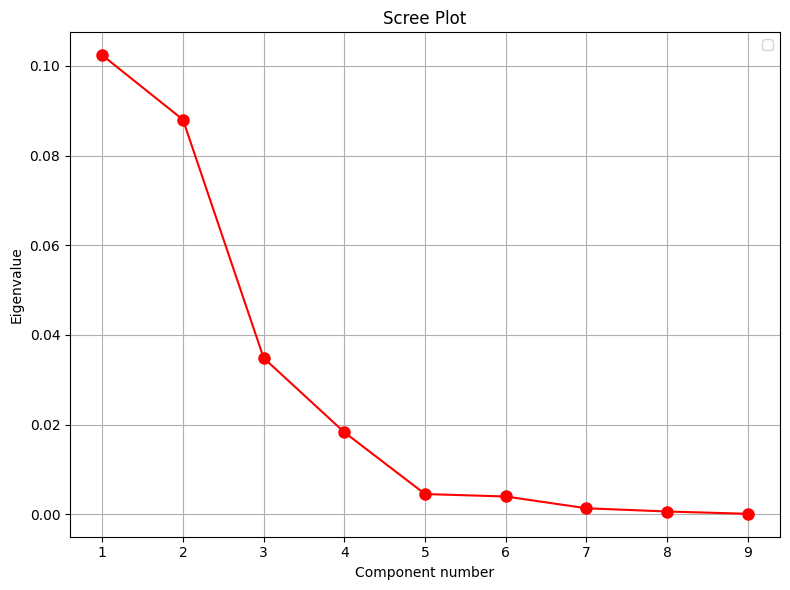

In [323]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming PCA has already been fitted (from your previous steps)
eigenvalues = pca.explained_variance_  # This gives you the eigenvalues for each component

# Create the scree plot
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(eigenvalues) + 1), eigenvalues, marker='o', color='red', linestyle='-', markersize=8)

# Labels and title
plt.xlabel('Component number')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.grid(True)

# Show the plot
plt.legend()
plt.tight_layout()
plt.show()

Principal Component 1: 0.4029 (Cumulative: 0.4029)
Principal Component 2: 0.3463 (Cumulative: 0.7492)
Principal Component 3: 0.1372 (Cumulative: 0.8864)
Principal Component 4: 0.0720 (Cumulative: 0.9584)
Principal Component 5: 0.0178 (Cumulative: 0.9762)
Principal Component 6: 0.0156 (Cumulative: 0.9918)
Principal Component 7: 0.0053 (Cumulative: 0.9971)
Principal Component 8: 0.0025 (Cumulative: 0.9996)
Principal Component 9: 0.0004 (Cumulative: 1.0000)


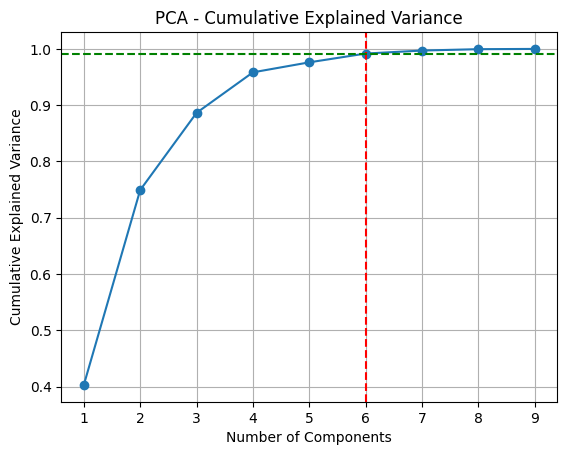

In [324]:
# Check explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Print the explained variance of each component and the cumulative variance
for i, (ev, cv) in enumerate(zip(explained_variance, cumulative_variance)):
    print(f"Principal Component {i+1}: {ev:.4f} (Cumulative: {cv:.4f})")

# Optionally plot the cumulative explained variance
import matplotlib.pyplot as plt

plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
#Plot a vertical line at 5 components and an horizontal line to see the explained variance
plt.axvline(x=6, color='red', linestyle='--')
plt.axhline(y=cumulative_variance[5], color='green', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Cumulative Explained Variance')
plt.grid(True)
plt.show()

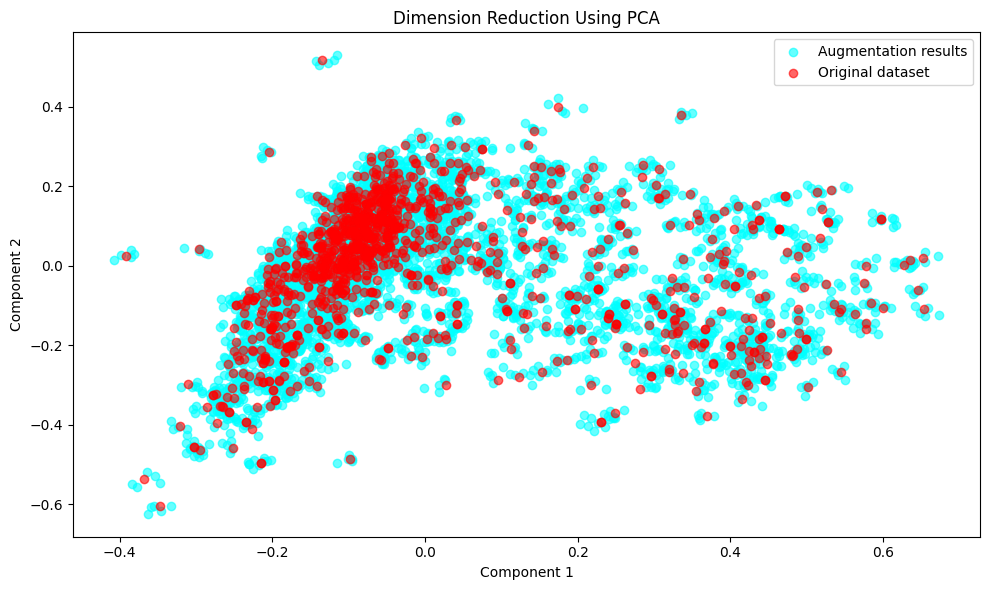

In [325]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Step 1: Apply PCA to reduce both original and augmented datasets to 2 components
pca_2d = PCA(n_components=2)

# Assuming X_train_combined is the original + augmented data
X_train_combined_pca_2d = pca_2d.fit_transform(X_train_combined)

# Separate PCA results for original and augmented datasets
X_train_pca_2d = X_train_combined_pca_2d[:X_train.shape[0]]  # First part is the original data
X_train_aug_pca_2d = X_train_combined_pca_2d[X_train.shape[0]:]  # Remaining part is the augmented data

# Step 2: Create the scatter plot
plt.figure(figsize=(10, 6))

# Plot augmented data in cyan
plt.scatter(X_train_aug_pca_2d[:, 0], X_train_aug_pca_2d[:, 1], color='cyan', label='Augmentation results', alpha=0.6)

# Plot original data in red
plt.scatter(X_train_pca_2d[:, 0], X_train_pca_2d[:, 1], color='red', label='Original dataset', alpha=0.6)

# Step 3: Add labels and title
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Dimension Reduction Using PCA')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [326]:
import numpy as np
import pandas as pd

# Calculate weights based on 15-bin histogram for each target
def calculate_weights(y, bins=15):
    # Calculate the bin frequencies for each target variable
    weights = np.zeros(y.shape)
    for i, col in enumerate(y.columns):
        hist, bin_edges = np.histogram(y[col], bins=bins)
        max_freq = np.max(hist)
        bin_weights = np.zeros(len(y[col]))

        # Assign weights based on the inverse of the bin frequency
        for j in range(bins):
            bin_mask = (y[col] >= bin_edges[j]) & (y[col] < bin_edges[j+1])
            freq = hist[j]
            if freq > 0:
                bin_weights[bin_mask] = max_freq / freq

        # If the value equals the last bin edge (e.g., max value), set the weight
        bin_weights[y[col] == bin_edges[-1]] = max_freq / hist[-1]
        weights[:, i] = bin_weights

    return weights

# Calculate weights for the augmented training set
sample_weights_combined = calculate_weights(pd.DataFrame(y_train_combined, columns=labels))

# Check the shape of the weights array
print(f"Shape of sample weights for augmented data: {sample_weights_combined.shape}")

Shape of sample weights for augmented data: (6828, 3)


In [327]:
# Use a grid search approach with TQDM to find the best hyperparameters for batch size, dropout rate, L2 regularization, and the number of epochs.

from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
import warnings # Hide warnings
warnings.filterwarnings('ignore')

# Define the hyperparameters to tune

param_grid = {
    'optimizer': ['adam'],  # Optimizers to test
    'dropout_rate': [0.1, 0.2, 0.3],  # Range of dropout rates
    'neurons': [32, 64],  # Number of neurons in each layer
    'epochs': [50, 100],  # Number of epochs
    'batch_size': [16, 32, 64],  # Batch sizes to test
    'l2_reg': [0.001, 0.01, 0.1]  # L2 regularization strength
}

# Create a grid of parameters
param_list = list(ParameterGrid(param_grid))

# Function to create a model with different hyperparameters
def create_model_with_params(dropout_rate=0.3, l2_reg=0.001, neurons=64, optimizer='adam'):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(X_train_combined_pca.shape[1],)))
    model.add(layers.Dense(neurons, kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(neurons//2, kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(neurons//4, kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dense(3, activation='sigmoid')) # instead of 'linear'
    model.compile(optimizer=optimizer, loss='mse')
    return model

In [328]:
# Track the best hyperparameters and their performance
best_params = None
best_score = float('inf')

# Calculate mean weights across all target variables
mean_sample_weights_combined = sample_weights_combined.mean(axis=1)

In [329]:
# Perform grid search with TQDM tracking
for params in tqdm(param_list):
    # Unpack the parameters of the param_grid
    optimizer = params['optimizer']
    dropout_rate = params['dropout_rate']
    neurons = params['neurons']
    epochs = params['epochs']
    batch_size = params['batch_size']
    l2_reg = params['l2_reg']

    # Create and train the model
    model = create_model_with_params(
        dropout_rate=dropout_rate, 
        l2_reg=l2_reg, 
        neurons=neurons, 
        optimizer=optimizer
    )

    # Train the model with sample weights for augmented data
    history = model.fit(
        X_train_combined_pca, 
        y_train_combined, 
        validation_data=(X_test_pca, y_test), 
        sample_weight=mean_sample_weights_combined,  # Using weights for augmented data
        epochs=epochs, 
        batch_size=batch_size, 
        verbose=0
    )
    
    # Evaluate the performance on the validation set
    val_loss = min(history.history['val_loss'])
    
    # Update the best parameters if this model is better
    if val_loss < best_score:
        best_score = val_loss
        best_params = params

# Output the best parameters
print(f"Best hyperparameters: {best_params}")
print(f"Best validation loss: {best_score}")

100%|██████████| 108/108 [56:42<00:00, 31.51s/it] 

Best hyperparameters: {'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 100, 'l2_reg': 0.001, 'neurons': 32, 'optimizer': 'adam'}
Best validation loss: 0.04611951485276222


In [330]:
#best_params = {'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 100, 'l2_reg': 0.001, 'neurons': 32, 'optimizer': 'adam'}

In [331]:
# Extract the best hyperparameters from the grid search results
best_optimizer = best_params['optimizer']
best_dropout_rate = best_params['dropout_rate']
best_neurons = best_params['neurons']
best_epochs = best_params['epochs']
best_batch_size = best_params['batch_size']
best_l2_reg = best_params['l2_reg']  # Extract l2_reg as well

Epoch 1/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3654 - val_loss: 0.1221
Epoch 2/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2288 - val_loss: 0.1068
Epoch 3/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2107 - val_loss: 0.0934
Epoch 4/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1994 - val_loss: 0.0840
Epoch 5/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1879 - val_loss: 0.0772
Epoch 6/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1787 - val_loss: 0.0723
Epoch 7/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1760 - val_loss: 0.0690
Epoch 8/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1701 - val_loss: 0.0652
Epoch 9/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1633 - val_loss: 0.0624
Epoch 10/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1632 - val_loss: 0.0617
Epoch 11/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1585 - val_loss: 0.0585
Epoch 12/100
214/214 ━━━━━━━━━━━━━━━━━━━━

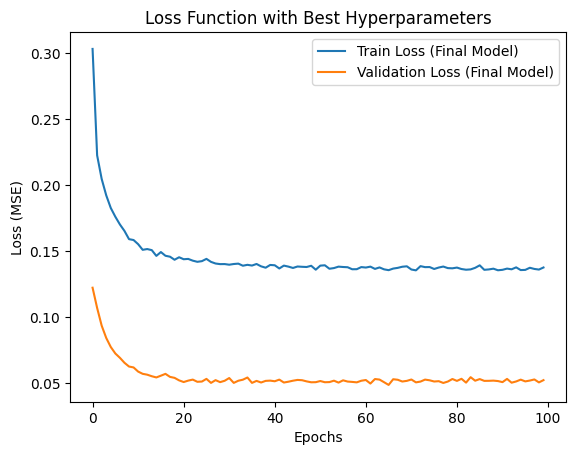

In [332]:
# Use the best hyperparameters identified from tuning
final_model = create_model_with_params(
    dropout_rate=best_dropout_rate, 
    l2_reg=best_l2_reg,  # Apply the best L2 regularization parameter
    optimizer=best_optimizer  # Apply the best optimizer
)

# Train the model using the best hyperparameters with sample weights
final_history = final_model.fit(
    X_train_combined_pca, 
    y_train_combined, 
    validation_data=(X_test_pca, y_test), 
    sample_weight=mean_sample_weights_combined,  # Include sample weights for training
    epochs=best_epochs, 
    batch_size=best_batch_size, 
    verbose=1
)

# Plot the Loss for the Final Model
plt.plot(final_history.history['loss'], label='Train Loss (Final Model)')
plt.plot(final_history.history['val_loss'], label='Validation Loss (Final Model)')
plt.title('Loss Function with Best Hyperparameters')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [ ]:
# We will calculate the normalized RMSE, MAE, and R² for each mineral.

# Predict on the test set with the final model
y_pred_final = final_model.predict(X_test_pca)

# Calculate metrics for the final model using column indices
rmse_calcite_final = np.sqrt(mean_squared_error(y_test[:, 0], y_pred_final[:, 0]))
nrmse_calcite_final = rmse_calcite_final / (y_test[:, 0].max() - y_test[:, 0].min())

rmse_clay_final = np.sqrt(mean_squared_error(y_test[:, 1], y_pred_final[:, 1]))
nrmse_clay_final = rmse_clay_final / (y_test[:, 1].max() - y_test[:, 1].min())

rmse_quartz_final = np.sqrt(mean_squared_error(y_test[:, 2], y_pred_final[:, 2]))
nrmse_quartz_final = rmse_quartz_final / (y_test[:, 2].max() - y_test[:, 2].min())

# MAE and nMAE for final model
mae_calcite_final = mean_absolute_error(y_test[:, 0], y_pred_final[:, 0])
nmae_calcite_final = mae_calcite_final / (y_test[:, 0].max() - y_test[:, 0].min())

mae_clay_final = mean_absolute_error(y_test[:, 1], y_pred_final[:, 1])
nmae_clay_final = mae_clay_final / (y_test[:, 1].max() - y_test[:, 1].min())

mae_quartz_final = mean_absolute_error(y_test[:, 2], y_pred_final[:, 2])
nmae_quartz_final = mae_quartz_final / (y_test[:, 2].max() - y_test[:, 2].min())

# R² for final model
r2_calcite_final = r2_score(y_test[:, 0], y_pred_final[:, 0])
r2_clay_final = r2_score(y_test[:, 1], y_pred_final[:, 1])
r2_quartz_final = r2_score(y_test[:, 2], y_pred_final[:, 2])

# Print final metrics
print(f"Final nRMSE for Carbonates: {nrmse_calcite_final:.2f}")
print(f"Final nRMSE for Clay: {nrmse_clay_final:.2f}")
print(f"Final nRMSE for Quartz: {nrmse_quartz_final:.2f}")

print(f"Final nMAE for Carbonates: {nmae_calcite_final:.2f}")
print(f"Final nMAE for Clay: {nmae_clay_final:.2f}")
print(f"Final nMAE for Quartz: {nmae_quartz_final:.2f}")

print(f"Final R² for Carbonates: {r2_calcite_final:.2f}")
print(f"Final R² for Clay: {r2_clay_final:.2f}")
print(f"Final R² for Quartz: {r2_quartz_final:.2f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Final nRMSE for Carbonates: 0.22
Final nRMSE for Clay: 0.22
Final nRMSE for Quartz: 0.22
Final nMAE for Carbonates: 0.16
Final nMAE for Clay: 0.16
Final nMAE for Quartz: 0.17
Final R² for Carbonates: 0.21
Final R² for Clay: 0.13
Final R² for Quartz: 0.24


In [334]:
y_pred_final

array([[0.24171264, 0.20104718, 0.6479585 ],
       [0.08368678, 0.590471  , 0.40730217],
       [0.49554452, 0.14413677, 0.4086985 ],
       ...,
       [0.247564  , 0.16047545, 0.6770396 ],
       [0.14664644, 0.28464076, 0.66815984],
       [0.17483328, 0.28207463, 0.63564223]], dtype=float32)

In [335]:
y_pred_original= label_scaler.inverse_transform(y_pred_final)
y_test_original= label_scaler.inverse_transform(y_test)

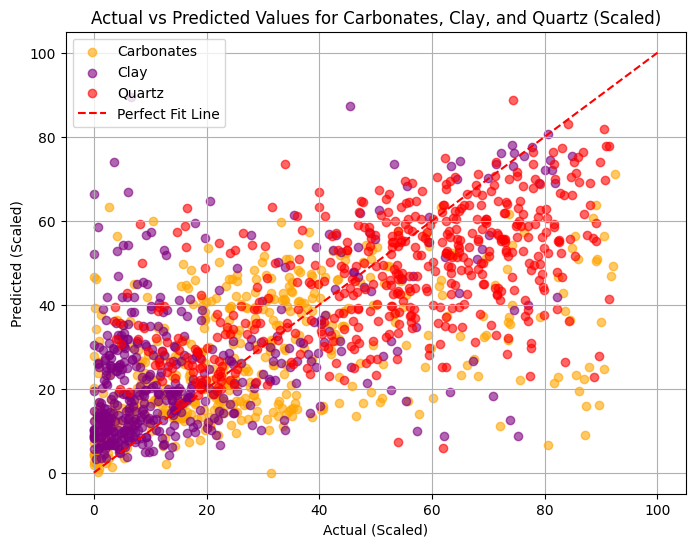

In [336]:
import matplotlib.pyplot as plt

# Create the plot in the scaled space directly
plt.figure(figsize=(8, 6))

# Plot for Carbonates
plt.scatter(y_test_original[:, 0], y_pred_original[:, 0], label='Carbonates', color='orange', alpha=0.6)

# Plot for Clay
plt.scatter(y_test_original[:, 1], y_pred_original[:, 1], label='Clay', color='purple', alpha=0.6)

# Plot for Quartz
plt.scatter(y_test_original[:, 2], y_pred_original[:, 2], label='Quartz', color='red', alpha=0.6)

# Plot the perfect fit line (diagonal for visual comparison)
plt.plot([0, 100], [0, 100], 'r--', label='Perfect Fit Line')

# Add labels and title
plt.xlabel('Actual (Scaled)')
plt.ylabel('Predicted (Scaled)')
plt.title('Actual vs Predicted Values for Carbonates, Clay, and Quartz (Scaled)')

# Add legend and show the plot
plt.legend()
plt.grid(True)
plt.show()